# Homework 5 - Taming text

## Introduction

In this homework, a large corpus of emails released in public during the Hillary Clinton email controversy will be explored. The corpus is stored in `Data` directory. More informtion of the schema is available [here](https://www.kaggle.com/kaggle/hillary-clinton-emails).

In [1]:
from os import path
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import string
import re
from nltk.corpus import stopwords
%matplotlib inline

## 1. Word clouds
Generate two word clouds:
* One based on the raw corpus
* One based on the corpus pre-processed using the standard text pipeline. 

### a. __Raw text__
#### @TODO: choose the text to take into account
The data we are going to use for producing the clouds is taken from the file `Emails.csv` and refers to the column `RawText`. Hence, before proceeding to build up a unique cloud, we sould concatenate all the `RawText` of the emails. In particular, we do the following:
* Import the data related to the Emails.

In [2]:
# Read data
emails = pd.read_csv('Data/Emails.csv', sep = ',')
emails.sample(10)
# MetadataSubject; 

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
731,732,C05759591,THANK YOU!,NaN,H,80.0,2009-09-13T04:00:00+00:00,2015-06-30T04:00:00+00:00,DOCUMENTS/HRCAll_1_1-29_JuneWEB/6_7_8/DOC_0C05...,F-2014-20439,...,NaN,H <hrod17@clintonemail.com >,NaN,"Sunday, September 13, 2009 4:10 PM",F-2014-20439,C05759591,06/30/2015,RELEASE IN PART,You are so welcome!,UNCLASSIFIED U.S. Department of State Case No....
7794,7795,C05776821,"H: ROGER COHEN IN NYT: ""AMERICAN DIPLOMA CY RE...",H,sbwhoeop,194.0,2010-12-04T05:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0111/DOC_0C0...,F-2014-20439,...,NaN,sbwhoeop,NaN,"Saturday, December 4, 2010 8:51 AM",F-2014-20439,C05776821,08/31/2015,RELEASE IN PART,141737V7SMIZITMItlfaliZZI%\nGood luck out ther...,B6\nUNCLASSIFIED U.S. Department of State Case...
5720,5721,C05770765,RE:,H,"Verma, Richard R",180.0,2010-05-27T04:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0081/DOC_0C0...,F-2014-20439,...,NaN,"Verma, Richard R <VermaRR©state.goy>",NaN,"Thursday, May 27, 2010 7:31 PM",F-2014-20439,C05770765,08/31/2015,RELEASE IN FULL,One could serve till the end of 2011. And if r...,UNCLASSIFIED U.S. Department of State Case No....
7563,7564,C05775315,BOMB AT SUFI SHRINE,sullivanjj@state.gov,H,80.0,2010-07-01T04:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0128/DOC_0C0...,F-2014-20439,...,'sullivanjj@state.gov',H <hrod17@clintonemail.corn>,NaN,"Thursday, July 1, 2010 6:25 PM",F-2014-20439,C05775315,08/31/2015,RELEASE IN FULL,Can you get me more info about the shrine?,UNCLASSIFIED U.S. Department of State Case No....
6444,6445,C05772172,(AP) FAMILY SPOKESMAN SAYS AMERICAN BUSINESSMA...,H,"Abedin, Huma",81.0,2010-10-16T04:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0103/DOC_0C0...,F-2014-20439,...,NaN,"Abedin, Huma <AbedinH@state.gov>",SES-0_05; SES-O_Shift-11,"Saturday, October 16, 2010 3:50 PM",F-2014-20439,C05772172,08/31/2015,RELEASE IN FULL,been released\nReza teghavi\nBusinessman from ...,UNCLASSIFIED U.S. Department of State Case No....
1921,1922,C05762459,"YOUR JUNE 22, 2009 ARTICLE ON THE PRAGUE CONFE...",H,"Mills, Cheryl D",32.0,2009-06-22T04:00:00+00:00,2015-06-30T04:00:00+00:00,DOCUMENTS/HRCAll_1_1-29_JuneWEB/AddBacks/DOC_0...,F-2014-20439,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Kennedy, J Christian;","Monday, June 22, 2009 8:00 AM",F-2014-20439,C05762459,06/30/2015,RELEASE IN PART,FYI,B6\nUNCLASSIFIED U.S. Department of State Case...
6451,6452,C05772194,INVITE FOR KALA LENHART GMMB,H,"Mills, Cheryl D",32.0,2010-09-21T04:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0098/DOC_0C0...,F-2014-20439,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Smith, Jeannemarie E; Haslach, Patricia M","Tuesday, September 21, 2010 6:14 PM",F-2014-20439,C05772194,08/31/2015,RELEASE IN PART,Fyi,UNCLASSIFIED U.S. Department of State Case No....
7590,7591,C05775445,HAPPY BIRTHDAY MY DEAR,H,"Mills, Cheryl D",32.0,2010-10-26T04:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0104/DOC_0C0...,F-2014-20439,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>",NaN,"Tuesday, October 26, 2010 6:36 AM",F-2014-20439,C05775445,08/31/2015,RELEASE IN FULL,So glad you were born!\nKiss your mom for me -...,UNCLASSIFIED U.S. Department of State Case No....
3318,3319,C05765839,BREAKING NEWS ON MD ROLL OUT,H,"Mills, Cheryl D",32.0,2009-09-11T04:00:00+00:00,2015-07-31T04:00:00+00:00,DOCUMENTS/HRCEmail_JulyWeb/Web_037/DOC_0C05765...,F-2014-20439,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>",NaN,"Friday, September 11, 2009 5:45 PM",F-2014-20439,C05765839,07/31/2015,RELEASE IN PART,FYI more — I've spoken to Jim who is addressin...,U

In [3]:
index_null = emails[emails['MetadataSubject'].isnull()].index
index_null_extracted = emails[emails['ExtractedSubject'].isnull()].index#, 'ExtractedSubject']]

In [4]:
# Number that should remain null
len(set(index_null).intersection(set(index_null_extracted)))

250

In [5]:
for i in index_null:
    emails.loc[i,'MetadataSubject'] = emails.loc[i, 'ExtractedSubject']

In [6]:
# Get the subject (replacing na)
emails['MetadataSubject'].fillna('No title', inplace = True)

In [7]:
# Get bodies
emails['ExtractedBodyText'].fillna('No body text', inplace = True)

* Extract the column relates to the `RawText`.

In [8]:
# Useful data
email_corpus = emails[['MetadataSubject', 'ExtractedBodyText']]

* Create a *unique* corpus.

We choose the columns of the data that provide some useful information - merged columns for subject of the email and also body text.

In [9]:
# Create the corpus
unique_corpus_1 = ' '.join([email_corpus['MetadataSubject'][i] for i in range(len(email_corpus))])
unique_corpus_2 = ' '.join([email_corpus['ExtractedBodyText'][i] for i in range(len(email_corpus))])
corpus = [unique_corpus_1] + [unique_corpus_2]

In [10]:
unique_corpus = ' '.join(corpus)

At first we remove all the characters that contain punctuation.

In [11]:
for c in string.punctuation:
    unique_corpus = unique_corpus.replace(c," ")

Thus, we generate the word cloud. For the moment, in order to indentify the most frequent words, we decide not to fix the maximum font size.

In [12]:
# Generate the word cloud 
wordcloud = WordCloud().generate(unique_corpus)

Visualize the output cloud!

(-0.5, 399.5, 199.5, -0.5)

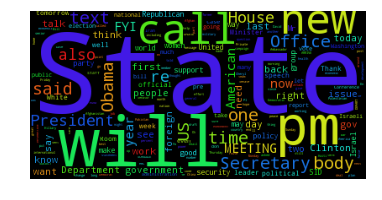

In [13]:
# Display the generated cloud
plt.imshow(wordcloud)
plt.axis("off")

### b. Pre-processed text

To preprocess the text we proceed applying the standard pipeline that includes:
* Tokenization
* Stop-words
* Stemming

We tokenize the corpus and we receive the list of words to further procedure.

In [14]:
text = nltk.word_tokenize(unique_corpus)

In [15]:
len(text)

667487

We remove meaningless, short tokens and we put the rest of them into lowercase.

In [16]:
text_token = [i.lower() for i in text if len(i) > 2]

In [17]:
len(text_token)

505321

We use stopword list extended by the common words we found in the cloud above.

In [18]:
stop_words = set(stopwords.words('english') + ['body', 'text', 'said', 'time','new', 'fyi', 'also', 'first', 'work', 'make', 'call', 'right',
                                               "n't", 'say', 'talk', 'call', 'need', 'one', 'meet', 'today', 'see', 'two', 'year', 'would',
                                               'know', 'would', 'get', 'time', 'morning', 'like', 'back', 'tomorrow', 'think', 'good', 'want',
                                               'could', 'working', 'well', 'house', 'come', 'calling', 'day', 'ask', 'tell', 'states', 'gov',
                                               'secretary', 'state', 'years', 'may', 'last', 'way', 'speech', 'party', 'week', 'thank',
                                               'room', 'many', 'even', 'case', 'much', 'let', 'going', 'take', 'says', 'point', 'next',
                                               'schedule', 'called', 'still', 'told', 'made', 'monday', 'news', 'another', 'long', 'best',
                                               'date', 'tuesday', 'wednesday', 'thursday', 'friday', 'pls'])

In [19]:
filtered_words = [word for word in text_token if word not in stop_words]

We considered using stemming techniques but we abandoned this idea while it couldn't give us more descriptive view of the email content. Also we find not stemmed words easier to proceed.

In [20]:
clean_corpus = ' '.join(filtered_words)

In [21]:
words_cloud = WordCloud().generate(clean_corpus)

In [22]:
words_cloud.words_

[('obama', 1.0),
 ('office', 0.9432950191570881),
 ('president', 0.9371647509578545),
 ('american', 0.7593869731800766),
 ('meeting', 0.7448275862068966),
 ('department', 0.6904214559386973),
 ('government', 0.6551724137931034),
 ('clinton', 0.6505747126436782),
 ('people', 0.6413793103448275),
 ('foreign', 0.5547892720306513),
 ('issue', 0.5088122605363985),
 ('republican', 0.4735632183908046),
 ('women', 0.4582375478927203),
 ('security', 0.4574712643678161),
 ('policy', 0.4528735632183908),
 ('sid', 0.4482758620689655),
 ('israel', 0.4467432950191571),
 ('world', 0.43524904214559385),
 ('support', 0.4329501915708812),
 ('united', 0.4306513409961686),
 ('group', 0.4298850574712644),
 ('political', 0.4191570881226054),
 ('leader', 0.4099616858237548),
 ('minister', 0.4091954022988506),
 ('official', 0.4),
 ('white', 0.3938697318007663),
 ('washington', 0.39080459770114945),
 ('report', 0.38084291187739466),
 ('national', 0.3685823754789272),
 ('bill', 0.3632183908045977),
 ('public', 

(-0.5, 399.5, 199.5, -0.5)

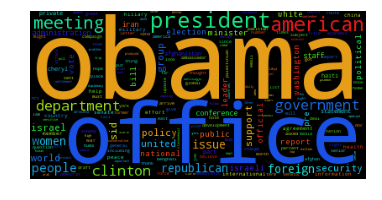

In [23]:
plt.imshow(WordCloud().generate(clean_corpus))
plt.axis("off")

## 2.
Find all the mentions of world countries in the whole corpus, using the pycountry utility (HINT: remember that there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.) Perform sentiment analysis on every email message using the demo methods in the nltk.sentiment.util module. Aggregate the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level) that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo methods from the sentiment analysis module -- can you find substantial differences?

In [24]:
def clean_body(x):
    
    # IMPORTANT STOPWORD IS A VARIABLE ALREADY DECLEARED OUTSIDE
    
    # Tokenize
    text = nltk.word_tokenize(x)
    
    # Replace the comma adding space and go to lowercase
    replace_comma = [(i.replace(',', ', ')).lower() for i in text]
    #print (replace_comma)
    # Get rid of this list of two letters words
    get_rid = list(stop_words) + ["re", "fm", "tv", "al", "aq", "la", "ben", "no", "pm", 'cc', 'com', 'mr', 'us', 'fw']
    list_words = [i for i in replace_comma if i not in get_rid and len(i) > 1]
       
    # Get back to the string
    join_list = " ".join(list_words)
    
    # Remove all the punctuation
    for c in string.punctuation:
        join_list = join_list.replace(c," ")
    
    text_new = nltk.word_tokenize(join_list)
    get_rid = list(stop_words) + ["re", "fm", "tv", "al", "aq", "la", "ben", "no", "pm", 'cc', 'com', 'mr', 'us', 'fw']
    list_words = [i for i in text_new if i not in get_rid and len(i) > 1]
    
    return list_words

In [25]:
from functools import partial

In [26]:
emails['ExtractedBodyText_2'] = emails['ExtractedBodyText'].apply(clean_body)

In [27]:
import pycountry

In [28]:
list(pycountry.countries)

[Country(alpha_2='AW', alpha_3='ABW', name='Aruba', numeric='533'),
 Country(alpha_2='AF', alpha_3='AFG', name='Afghanistan', numeric='004', official_name='Islamic Republic of Afghanistan'),
 Country(alpha_2='AO', alpha_3='AGO', name='Angola', numeric='024', official_name='Republic of Angola'),
 Country(alpha_2='AI', alpha_3='AIA', name='Anguilla', numeric='660'),
 Country(alpha_2='AX', alpha_3='ALA', name='Åland Islands', numeric='248'),
 Country(alpha_2='AL', alpha_3='ALB', name='Albania', numeric='008', official_name='Republic of Albania'),
 Country(alpha_2='AD', alpha_3='AND', name='Andorra', numeric='020', official_name='Principality of Andorra'),
 Country(alpha_2='AE', alpha_3='ARE', name='United Arab Emirates', numeric='784'),
 Country(alpha_2='AR', alpha_3='ARG', name='Argentina', numeric='032', official_name='Argentine Republic'),
 Country(alpha_2='AM', alpha_3='ARM', name='Armenia', numeric='051', official_name='Republic of Armenia'),
 Country(alpha_2='AS', alpha_3='ASM', nam

In [29]:
list_country = list(pycountry.countries)
country_dictionary = {}
country_set = []
for country in list_country:
    country_dictionary[(country.name).lower()] = [(country.alpha_2).lower(), (country.alpha_3).lower()]
    
    if (country.name).lower() == 'syrian arab republic':
        country_dictionary[(country.name).lower()] += ['syria']
    elif (country.name).lower() == 'russian federation':
        country_dictionary[(country.name).lower()] += ['russia']
    elif (country.name).lower() == 'united kingdomn':
        country_dictionary[(country.name).lower()] += ['uk', 'great britain']
    
    country_set.append((country.alpha_2).lower())
    country_set.append((country.alpha_3).lower())
    country_set.append((country.name).lower())
    
country_set += ['syria', 'russia', 'uk', 'great britain']
country_set = set(country_set)

In [84]:
from collections import defaultdict
mentions_dictionary = defaultdict(int)

In [85]:
keys = list(country_dictionary.keys())

for mail in emails['ExtractedBodyText_2']:
    for i in set(mail):
        if i in country_set:  
            
            # Insert the sentiment analysis add values to dictionary
            
            print (i)
            for k in keys:

                if k == i:
                    print ('if',k)
                    mentions_dictionary[k] += 1


                else:

                    values = country_dictionary[k]

                    for v in values:
                        if v == i:
                            print ('else', k)
                            mentions_dictionary[k] += 1                      

libya
if libya
syria
else syrian arab republic
libya
if libya
syria
else syrian arab republic
libya
if libya
syria
else syrian arab republic
libya
if libya
libya
if libya
arm
else armenia
col
else colombia
iraq
if iraq
russia
else russian federation
mn
else mongolia
libya
if libya
china
if china
france
if france
afghanistan
if afghanistan
libya
if libya
malta
if malta
libya
if libya
libya
if libya
libya
if libya
yemen
if yemen
egypt
if egypt
libya
if libya
yemen
if yemen
syria
else syrian arab republic
chad
if chad
qa
else qatar
egypt
if egypt
mm
else myanmar
libya
if libya
israel
if israel
na
else namibia
france
if france
gi
else gibraltar
egypt
if egypt
libya
if libya
tun
else tunisia
ws
else samoa
libya
if libya
cy
else cyprus
lie
else liechtenstein
ai
else anguilla
libya
if libya
aia
else anguilla
egypt
if egypt
libya
if libya
iraq
if iraq
egypt
if egypt
libya
if libya
syria
else syrian arab republic
israel
if israel
egypt
if egypt
libya
if libya
fin
else finland
ago
else angola
pg

In [86]:
mentions_dictionary

defaultdict(int,
            {'afghanistan': 130,
             'albania': 2,
             'algeria': 3,
             'andorra': 22,
             'angola': 127,
             'anguilla': 9,
             'antarctica': 2,
             'antigua and barbuda': 2,
             'argentina': 15,
             'armenia': 19,
             'australia': 25,
             'austria': 5,
             'azerbaijan': 11,
             'bahamas': 2,
             'bahrain': 3,
             'bangladesh': 6,
             'barbados': 11,
             'belarus': 1,
             'belgium': 6,
             'bermuda': 5,
             'bhutan': 2,
             'bolivia, plurinational state of': 1,
             'bosnia and herzegovina': 2,
             'brazil': 31,
             'british indian ocean territory': 2,
             'brunei darussalam': 6,
             'burundi': 10,
             'cabo verde': 5,
             'cambodia': 2,
             'cameroon': 5,
             'canada': 157,
             'cayman islands

In [91]:
# Keep countries with mentions greater than 50
dict_big_mentions = {}
for c in list(mentions_dictionary.keys()):
    if mentions_dictionary[c] > 30:
        dict_big_mentions[c] = mentions_dictionary[c]

In [92]:
dict_big_mentions

{'afghanistan': 130,
 'angola': 127,
 'brazil': 31,
 'canada': 157,
 'china': 95,
 'colombia': 95,
 'egypt': 36,
 'france': 32,
 'germany': 57,
 'haiti': 84,
 'india': 59,
 'indonesia': 37,
 'iraq': 71,
 'ireland': 39,
 'israel': 97,
 'jamaica': 37,
 'libya': 60,
 'mexico': 39,
 'montserrat': 55,
 'pakistan': 96,
 'panama': 36,
 'peru': 72,
 'russian federation': 55,
 'sao tome and principe': 37,
 'senegal': 38,
 'turkey': 36}

In [35]:
import operator

In [36]:
sorted_dict = sorted(dict_big_mentions.items(), key=operator.itemgetter(1))

In [37]:
sorted_dict

[('morocco', 64),
 ('palau', 64),
 ('colombia', 74),
 ('india', 81),
 ('canada', 81),
 ('ireland', 82),
 ('peru', 85),
 ('iraq', 89),
 ('angola', 93),
 ('israel', 104),
 ('pakistan', 132),
 ('libya', 172),
 ('haiti', 173),
 ('afghanistan', 177),
 ('china', 281)]

In [38]:
import seaborn as sns

In [39]:
sorted_dict[0]

('morocco', 64)

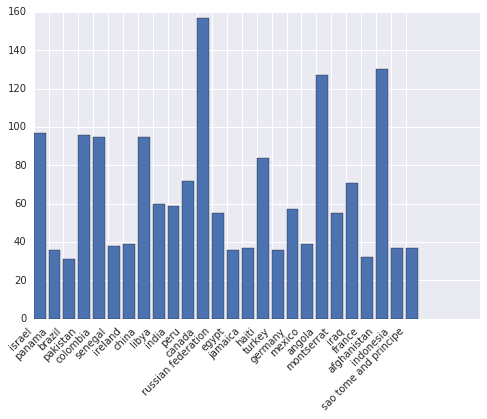

In [93]:
import matplotlib.pyplot as plt

plt.bar(range(len(dict_big_mentions)), list(dict_big_mentions.values()))
plt.xticks(range(len(dict_big_mentions)), list(dict_big_mentions.keys()))
plt.xticks(rotation=45, ha='right')
plt.show()

In [41]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
for text in emails['ExtractedBodyText']:
    analyzer = SentimentIntensityAnalyzer()
    c = analyzer.polarity_scores(text)
    print (c)

{'neu': 0.476, 'compound': -0.296, 'pos': 0.0, 'neg': 0.524}
{'neu': 1.0, 'compound': 0.0, 'pos': 0.0, 'neg': 0.0}
{'neu': 0.0, 'compound': 0.3612, 'pos': 1.0, 'neg': 0.0}
{'neu': 0.476, 'compound': -0.296, 'pos': 0.0, 'neg': 0.524}
{'neu': 1.0, 'compound': 0.0, 'pos': 0.0, 'neg': 0.0}
{'neu': 0.821, 'compound': -0.8402, 'pos': 0.039, 'neg': 0.14}
{'neu': 0.476, 'compound': -0.296, 'pos': 0.0, 'neg': 0.524}
{'neu': 1.0, 'compound': 0.0, 'pos': 0.0, 'neg': 0.0}
{'neu': 0.0, 'compound': 0.2023, 'pos': 1.0, 'neg': 0.0}
{'neu': 1.0, 'compound': 0.0, 'pos': 0.0, 'neg': 0.0}
{'neu': 0.357, 'compound': 0.2023, 'pos': 0.643, 'neg': 0.0}
{'neu': 1.0, 'compound': 0.0, 'pos': 0.0, 'neg': 0.0}
{'neu': 0.0, 'compound': 0.2023, 'pos': 1.0, 'neg': 0.0}
{'neu': 0.8, 'compound': 0.9881, 'pos': 0.111, 'neg': 0.089}
{'neu': 0.786, 'compound': 0.9259, 'pos': 0.188, 'neg': 0.026}
{'neu': 0.795, 'compound': 0.8869, 'pos': 0.137, 'neg': 0.069}
{'neu': 0.633, 'compound': 0.4404, 'pos': 0.367, 'neg': 0.0}
{'ne

In [81]:
a

"Pls print.\nH <hrod17@clintonemail.com >\nSunday, October 11, 2009 5:03 PM\n'JilotyLC@state.gov'\nFw: Thanks so much for the talk"

In [82]:
analyzer = SentimentIntensityAnalyzer()

In [83]:
analyzer.polarity_scores(a)

{'compound': 0.4939, 'neg': 0.0, 'neu': 0.781, 'pos': 0.219}

## 3.

## 4. *BONUS*